# Ноутбук для тестировки разных архитектур на других данных

## Импорт библиотек

In [1]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout, MaxPooling2D
from keras.optimizers import Adam

## Загрузка данных и предобработка для модели

In [2]:
train_df = pd.read_csv("RU_texts/train.tsv", sep="\t", header=None)

train_df = train_df.rename({0: "image_name", 1: "label"}, axis=1)

train_df = train_df.dropna()

train_df

,image_name,label
0,aa1.png,Молдова
1,aa1007.png,продолжила борьбу
2,aa101.png,разработанные
3,aa1012.png,Плачи
4,aa1013.png,Гимны богам
...,...,...
72281,yob20539.png,Ответственность в/сл-
72282,yob20543.png,независимо
72283,yob20544.png,от воинского звания
72284,yob20545.png,воинской


In [3]:
def adjust_contrast(image):
    return tf.image.adjust_contrast(image, 2)


def distortion_free_resize(image, img_size):
    w, h = img_size
    image  = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
    
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
                  [pad_height_top, pad_height_bottom],
                  [pad_width_left, pad_width_right],
                  [0, 0]
                ]
        )
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)

    return image


# Preprocess images
def preprocess_image(image_path, target_size=(128, 32)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)  # Force grayscale
    image = distortion_free_resize(image, target_size)
    image = adjust_contrast(image)
    image = tf.image.per_image_standardization(image)
    return image

def load_images_and_labels(directory):
    preprocessed_images = []
    labels = []

    for filename in tqdm(os.listdir(directory)):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                image = preprocess_image(file_path)
                preprocessed_images.append(image)
                image_name = filename.split("_")[0]  # Adjust based on naming convention
                label = train_df[train_df["image_name"] == image_name]["label"].iloc[0]
                labels.append(label)
            except Exception as e:
                pass
    return np.array(preprocessed_images), np.array(labels)

In [4]:
# Load dataset
dataset_path = os.path.join("RU_texts", "train")

images, labels = load_images_and_labels(dataset_path)

100%|██████████| 72284/72284 [13:30<00:00, 89.17it/s] 


# С-RNN Model

### Создание списка всех символов

In [29]:
symbols = set(train_df["label"].to_string())
alphabets = set(" 0123456789:;?[]«»АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё")
alphabets = "".join(list(alphabets | symbols))

In [30]:
alphabets = '.ГЗдиhRсЖщбч,uВ»эУrхжгЩР;мОлtАФ!-Ш8pюЯy«7Дs\'п21?Пк+ц"cш4аbя%0eйы№ ЛЧ[ЦЙфxуе9тонЭo)С6НвiИК(ЕТр/БХь3]\nёъ5:=зМЮ'

### Функции для перевода символов в числа и обратно

In [31]:
max_str_len = 40 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

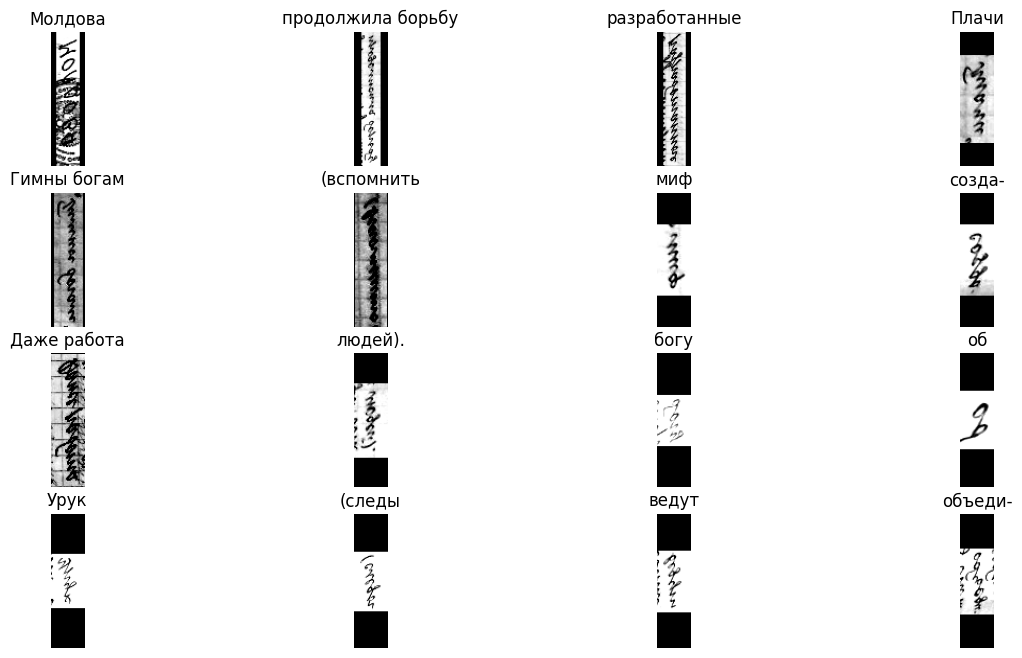

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(15, 8))

for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]
    # Gather indices where label!= 99.
    label = labels[i]
    ax[i // 4, i % 4].imshow(img, cmap="grey")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")


plt.show()

### Разделение на тренировочные и валидационные данные

In [36]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

In [37]:
train_size = len(x_train)
train_y = np.ones([train_size, max_str_len]) * len(alphabets)
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(y_train[i])
    train_y[i, 0:len(y_train[i])]= label_to_num(y_train[i]) 

In [38]:
valid_size = len(x_val)
valid_y = np.ones([valid_size, max_str_len]) * len(alphabets)
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(y_val[i])
    valid_y[i, 0:len(y_val[i])]= label_to_num(y_val[i])

In [40]:
input_data = Input(shape=(128, 32, 1), name='input')

inner = Conv2D(16, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(32, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.5)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.5)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 256)), name='reshape')(inner)
inner = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3), name = 'lstm2')(inner)

# Выходной слой
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense3')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

# Модель
model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 32)       320       
                                                                 
 batch_normalization_5 (Batc  (None, 128, 32, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 128, 32, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 64, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 64, 16, 64)        18496     
                                                           

In [13]:
input_data = Input(shape=(32, 64, 1), name='input')

inner = Conv2D(16, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(32, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max2')(inner)
inner = Dropout(0.5)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.5)(inner)

# b to c
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3), name = 'lstm2')(inner)

# Выходной слой
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense3')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

# Модель
model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 64, 1)]       0         
                                                                 
 conv2 (Conv2D)              (None, 32, 64, 32)        320       
                                                                 
 batch_normalization_1 (Batc  (None, 32, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 32, 64, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 32, 64, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 32, 64, 64)       256       
 hNormalization)                                             

In [39]:
# Размер входных данных (128x32, 1 канал)
input_data = Input(shape=(128, 32, 1), name='input')

# Первый сверточный блок
inner = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='conv1')(input_data)
inner = Activation('relu')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None, 64, 16, 64)
inner = Dropout(0.25)(inner)

# Второй сверточный блок
inner = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='conv2')(inner)
inner = Activation('relu')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 8, 128)
inner = Dropout(0.25)(inner)

# Третий сверточный блок
inner = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='conv4')(inner)
inner = Activation('relu')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D(pool_size=(2, 1), name='max3')(inner)  # (None, 16, 8, 256)
inner = Dropout(0.3)(inner)

# Четвёртый сверточный блок
inner = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='conv5')(inner)
inner = Activation('relu')(inner)
inner = BatchNormalization()(inner)
inner = Dropout(0.3)(inner)


# Преобразование в последовательность
inner = Reshape(target_shape=(64, -1), name='reshape')(inner)  # (None, 64, 1024)

# Полносвязный слой перед LSTM
inner = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)
inner = Dropout(0.5)(inner)

# Рекуррентные слои
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.6), name='lstm2')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.6), name='lstm3')(inner)

# Выходной слой
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

# Модель
model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 128, 32, 64)       640       
                                                                 
 activation_16 (Activation)  (None, 128, 32, 64)       0         
                                                                 
 batch_normalization_16 (Bat  (None, 128, 32, 64)      256       
 chNormalization)                                                
                                                                 
 max1 (MaxPooling2D)         (None, 64, 16, 64)        0         
                                                                 
 dropout_13 (Dropout)        (None, 64, 16, 64)        0         
                                                           

In [84]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Reshape, Dense, Bidirectional, LSTM
)
from tensorflow.keras.models import Model

# Размер входных данных (128x32, 1 канал)
input_data = Input(shape=(128, 32, 1), name='input')

# Первый сверточный блок
inner = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='conv1')(input_data)
inner = Activation('relu')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None, 64, 16, 64)
inner = Dropout(0.3)(inner)

# Второй сверточный блок
inner = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='conv2')(inner)
inner = Activation('relu')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 8, 128)
inner = Dropout(0.3)(inner)

# Третий сверточный блок
inner = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='conv4')(inner)
inner = Activation('relu')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D(pool_size=(2, 1), name='max3')(inner)  # (None, 16, 8, 256)
inner = Dropout(0.4)(inner)

# Четвёртый сверточный блок
inner = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='conv5')(inner)
inner = Activation('relu')(inner)
inner = BatchNormalization()(inner)
inner = Dropout(0.4)(inner)


# Преобразование в последовательность
inner = Reshape(target_shape=(64, -1), name='reshape')(inner)  # (None, 64, 1024)

# Полносвязный слой перед LSTM
inner = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)
inner = Dropout(0.3)(inner)

# Рекуррентные слои
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.5), name='lstm2')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.5), name='lstm3')(inner)

# Выходной слой
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

# Модель
model = Model(inputs=input_data, outputs=y_pred)
model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 128, 32, 64)       640       
                                                                 
 activation_21 (Activation)  (None, 128, 32, 64)       0         
                                                                 
 batch_normalization_21 (Bat  (None, 128, 32, 64)      256       
 chNormalization)                                                
                                                                 
 max1 (MaxPooling2D)         (None, 64, 16, 64)        0         
                                                                 
 dropout_18 (Dropout)        (None, 64, 16, 64)        0         
                                                           

In [41]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [42]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [43]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='recognizer_model.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [45]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.001))

with tf.device("/GPU:0"):
    history = model_final.fit(x=[x_train, train_y, train_input_len, train_label_len], y=train_output, 
        validation_data=([x_val, valid_y, valid_input_len, valid_label_len], valid_output),
        epochs=60, batch_size=128, verbose=1, callbacks=callbacks)

Epoch 1/60
509/509 [==============================] - 143s 273ms/step - loss: 26.9443 - val_loss: 25.7035
Epoch 2/60
509/509 [==============================] - 132s 258ms/step - loss: 24.6527 - val_loss: 23.4481
Epoch 3/60
509/509 [==============================] - 128s 251ms/step - loss: 22.0362 - val_loss: 19.0243
Epoch 4/60
509/509 [==============================] - 123s 242ms/step - loss: 17.2496 - val_loss: 12.7368
Epoch 5/60
509/509 [==============================] - 118s 231ms/step - loss: 13.4032 - val_loss: 10.0034
Epoch 6/60
509/509 [==============================] - 112s 219ms/step - loss: 11.3291 - val_loss: 8.2781
Epoch 7/60
509/509 [==============================] - 112s 220ms/step - loss: 9.9876 - val_loss: 7.2904
Epoch 8/60
509/509 [==============================] - 111s 218ms/step - loss: 9.0249 - val_loss: 6.5706
Epoch 9/60
509/509 [==============================] - 108s 213ms/step - loss: 8.3160 - val_loss: 6.0286
Epoch 10/60
509/509 [==============================] 

In [49]:
with tf.device("/GPU:0"):
    history = model_final.fit(x=[x_train, train_y, train_input_len, train_label_len], y=train_output, 
        validation_data=([x_val, valid_y, valid_input_len, valid_label_len], valid_output),
        epochs=60, batch_size=128, verbose=1, callbacks=callbacks)

Epoch 1/60
509/509 [==============================] - 66s 129ms/step - loss: 3.0728 - val_loss: 3.4758
Epoch 2/60
509/509 [==============================] - 65s 127ms/step - loss: 3.0077 - val_loss: 3.4752
Epoch 3/60
509/509 [==============================] - 64s 125ms/step - loss: 2.9982 - val_loss: 3.5692
Epoch 4/60
509/509 [==============================] - 65s 128ms/step - loss: 2.9622 - val_loss: 3.4842
Epoch 5/60
509/509 [==============================] - 64s 126ms/step - loss: 2.9373 - val_loss: 3.4330
Epoch 6/60
509/509 [==============================] - 64s 125ms/step - loss: 2.8808 - val_loss: 3.4804
Epoch 7/60
509/509 [==============================] - 63s 124ms/step - loss: 2.9013 - val_loss: 3.5156
Epoch 8/60
509/509 [==============================] - 62s 122ms/step - loss: 2.8976 - val_loss: 3.5426
Epoch 9/60
509/509 [==============================] - 62s 122ms/step - loss: 2.8821 - val_loss: 3.5569
Epoch 10/60
509/509 [==============================] - 63s 124ms/step - l

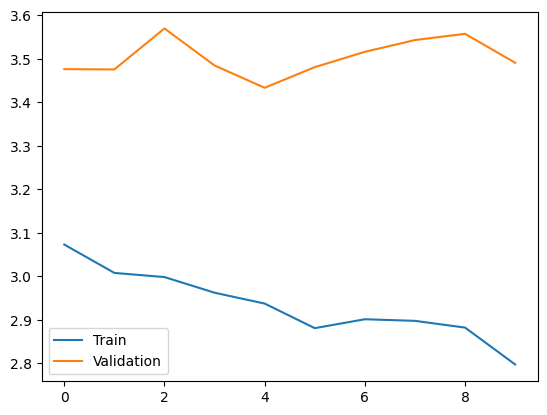

In [50]:
import matplotlib.pyplot as plt


plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.show()

### Тестирование модели (для упрощения - на валидационных данных)

In [51]:
preds = model.predict(x_val)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(len(y_val)):
    prediction.append(num_to_label(decoded[i]))

226/226 [==============================] - 3s 12ms/step


In [52]:
correct_char = 0
total_char = 0
correct = 0

for i in range(len(y_val)):
    pr = prediction[i]
    tr = y_val[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/len(x_val)))

Correct characters predicted : 79.74%
Correct words predicted      : 54.70%
